In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
path1 = 'Dataset/covid_19_india.csv'
path2 = 'Dataset/covid_vaccine_statewise.csv'
path3 = 'Dataset/StatewiseTestingDetails.csv'

dataindia = pd.read_csv(path1)
vaccineState = pd.read_csv(path2)
stateTesting = pd.read_csv(path3)

In [24]:
dataindia.isnull().sum()

Sno                         0
Date                        0
Time                        0
State/UnionTerritory        0
ConfirmedIndianNational     0
ConfirmedForeignNational    0
Cured                       0
Deaths                      0
Confirmed                   0
dtype: int64

In [25]:
vaccineState.isnull().sum()

Updated On                                0
State                                     0
Total Doses Administered                224
Sessions                                224
 Sites                                  224
First Dose Administered                 224
Second Dose Administered                224
Male (Doses Administered)               384
Female (Doses Administered)             384
Transgender (Doses Administered)        384
 Covaxin (Doses Administered)           224
CoviShield (Doses Administered)         224
Sputnik V (Doses Administered)         4850
AEFI                                   2407
18-44 Years (Doses Administered)       6143
45-60 Years (Doses Administered)       6143
60+ Years (Doses Administered)         6143
18-44 Years(Individuals Vaccinated)    4112
45-60 Years(Individuals Vaccinated)    4111
60+ Years(Individuals Vaccinated)      4111
Male(Individuals Vaccinated)           7685
Female(Individuals Vaccinated)         7685
Transgender(Individuals Vaccinat

In [26]:
stateTesting.isnull().sum()

Date                0
State               0
TotalSamples        0
Negative         9367
Positive        10674
dtype: int64

In [ ]:
# --- FIX DATE FORMATS ---
dataindia['Date'] = pd.to_datetime(dataindia['Date'], dayfirst=True)
vaccineState['Updated On'] = pd.to_datetime(vaccineState['Updated On'], dayfirst=True)
stateTesting['Date'] = pd.to_datetime(stateTesting['Date'], dayfirst=True) 

vaccineState.rename(columns={'Updated On': 'Date'}, inplace=True)

C:\Users\iiiaamnooob\AppData\Local\Temp\ipykernel_13528\55086502.py:3: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  stateTesting['Date'] = pd.to_datetime(stateTesting['Date'], dayfirst=True)


In [ ]:
# --- CLEAN COVID CASES DATA ---
dataindia.drop(columns=['Sno', 'Time', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], inplace=True)
dataindia.rename(columns={'State/UnionTerritory': 'State'}, inplace=True)

state_corrections = {
    'Telengana': 'Telangana',
    'Himanchal Pradesh': 'Himachal Pradesh',
    'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu'
}
dataindia['State'] = dataindia['State'].replace(state_corrections)

dataindia['Active'] = dataindia['Confirmed'] - dataindia['Cured'] - dataindia['Deaths']

In [ ]:
# --- HANDLE MISSING VALUES ---
vaccineState.dropna(subset=['Total Doses Administered'], inplace=True)
vaccineState.fillna(0, inplace=True)

stateTesting['TotalSamples'] = pd.to_numeric(stateTesting['TotalSamples'], errors='coerce')
stateTesting['Positive'] = pd.to_numeric(stateTesting['Positive'], errors='coerce')

mask = stateTesting['Negative'].isnull()
stateTesting.loc[mask, 'Negative'] = stateTesting.loc[mask, 'TotalSamples'] - stateTesting.loc[mask, 'Positive']

stateTesting.dropna(subset=['TotalSamples', 'Positive'], inplace=True)

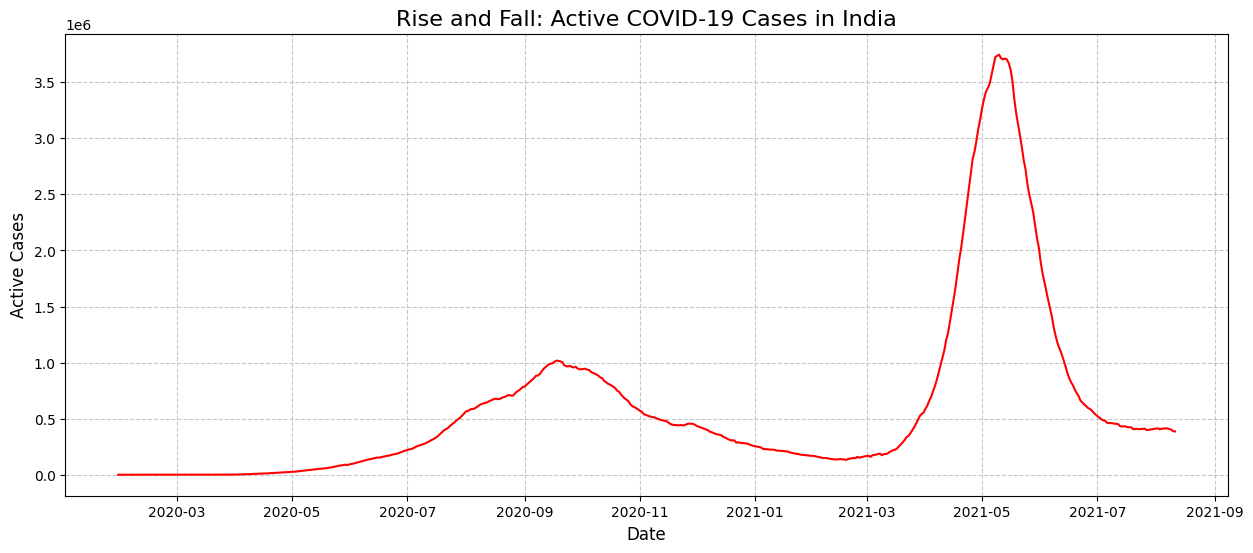

In [33]:
# --- VISUALIZATION ----


# 1. How did the pandemic unfold in India over time?
india_daily = dataindia.groupby('Date')[['Confirmed', 'Cured', 'Deaths', 'Active']].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=india_daily, x='Date', y='Active', color='red')
plt.title('Rise and Fall: Active COVID-19 Cases in India', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Active Cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

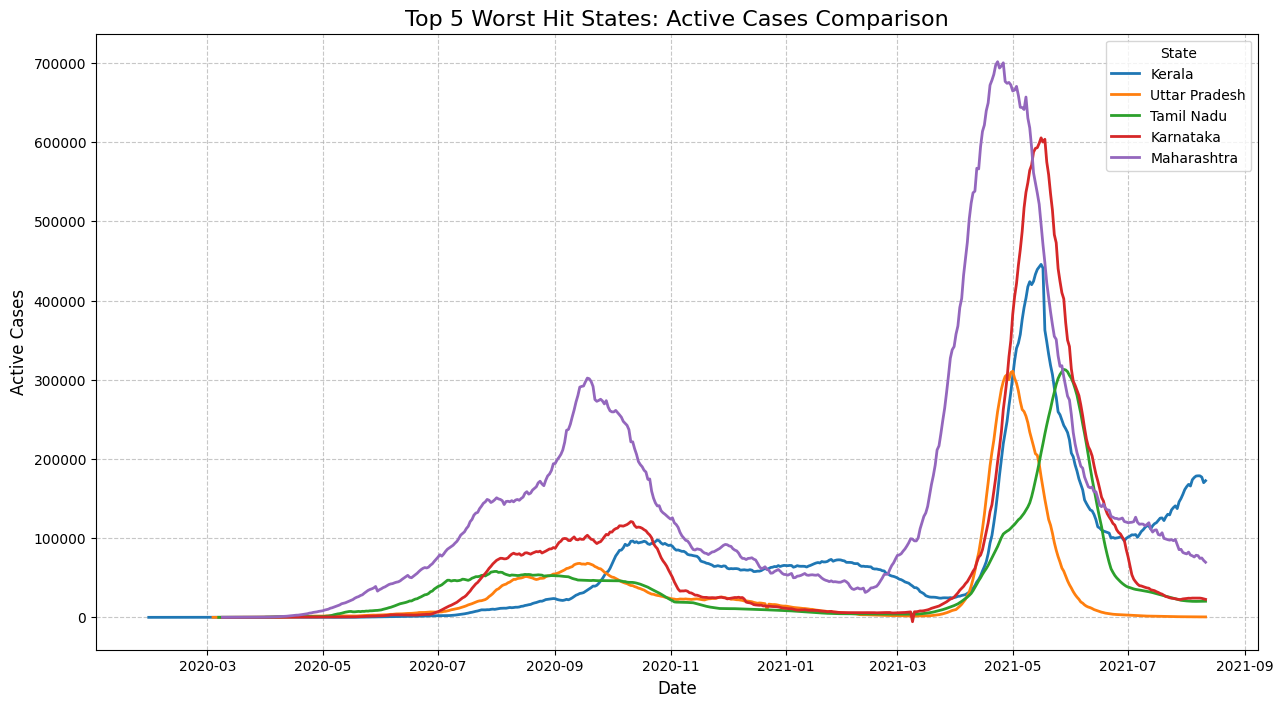

In [35]:
top_states = dataindia.groupby('State')['Active'].max().sort_values(ascending=False).head(5).index
top_states_df = dataindia[dataindia['State'].isin(top_states)]

plt.figure(figsize=(15, 8))
sns.lineplot(data=top_states_df, x='Date', y='Active', hue='State', linewidth=2)

plt.title('Top 5 Worst Hit States: Active Cases Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Active Cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='State')

plt.show()

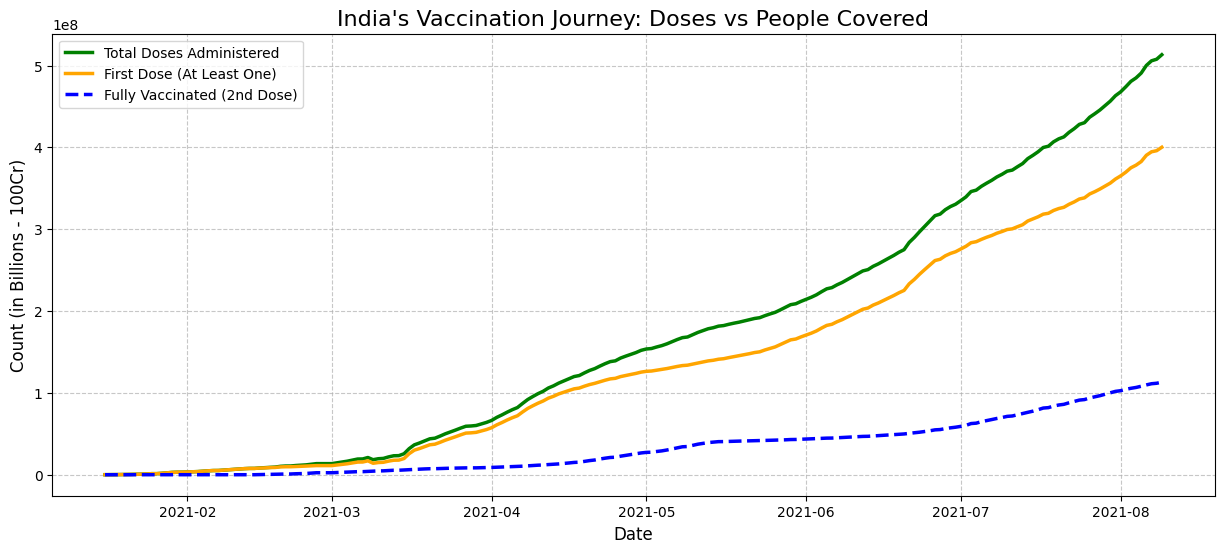

In [43]:
vaccine_india = vaccineState[vaccineState['State'] == 'India']

plt.figure(figsize=(15, 6))
sns.lineplot(data=vaccine_india, x='Date', y='Total Doses Administered', color='green', linewidth=2.5, label='Total Doses Administered')

sns.lineplot(data=vaccine_india, x='Date', y='First Dose Administered', color='orange', linewidth=2.5, linestyle='-', label='First Dose (At Least One)')

sns.lineplot(data=vaccine_india, x='Date', y='Second Dose Administered', color='blue', linewidth=2.5, linestyle='--', label='Fully Vaccinated (2nd Dose)')

plt.title('India\'s Vaccination Journey: Doses vs People Covered', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count (in Billions - 100Cr)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

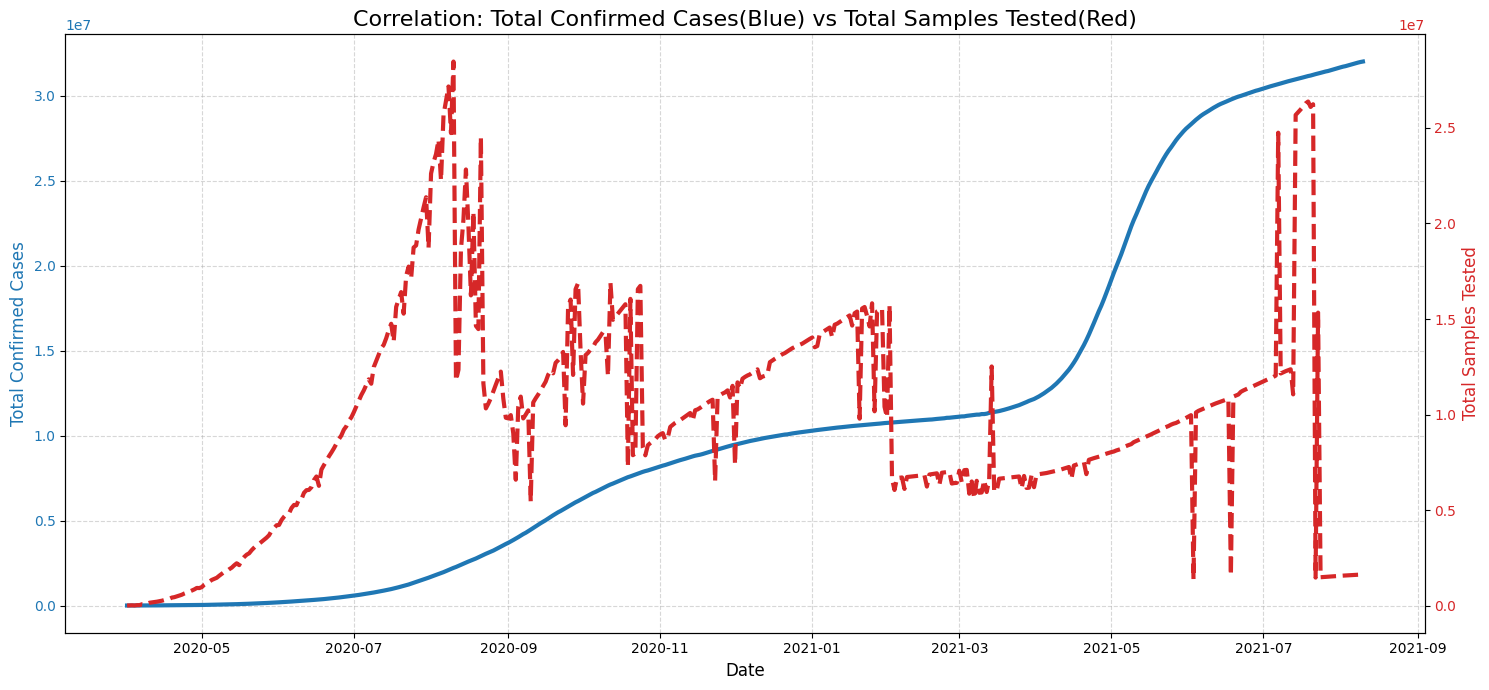

In [46]:
india_testing = stateTesting.groupby('Date')['TotalSamples'].sum().reset_index()

merged_df = pd.merge(india_daily, india_testing, on='Date', how='inner')

fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Total Confirmed Cases', color=color, fontsize=12)
ax1.plot(merged_df['Date'], merged_df['Confirmed'], color=color, linewidth=3, label='Confirmed Cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Total Samples Tested', color=color, fontsize=12)
ax2.plot(merged_df['Date'], merged_df['TotalSamples'], color=color, linewidth=3, linestyle='--', label='Total Samples Tested')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Correlation: Total Confirmed Cases(Blue) vs Total Samples Tested(Red)', fontsize=16)
fig.tight_layout()

plt.show()

C:\Users\iiiaamnooob\AppData\Local\Temp\ipykernel_13528\3753384633.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=top_10_mortality, x='Death_Ratio', y='State', palette='Reds_r')


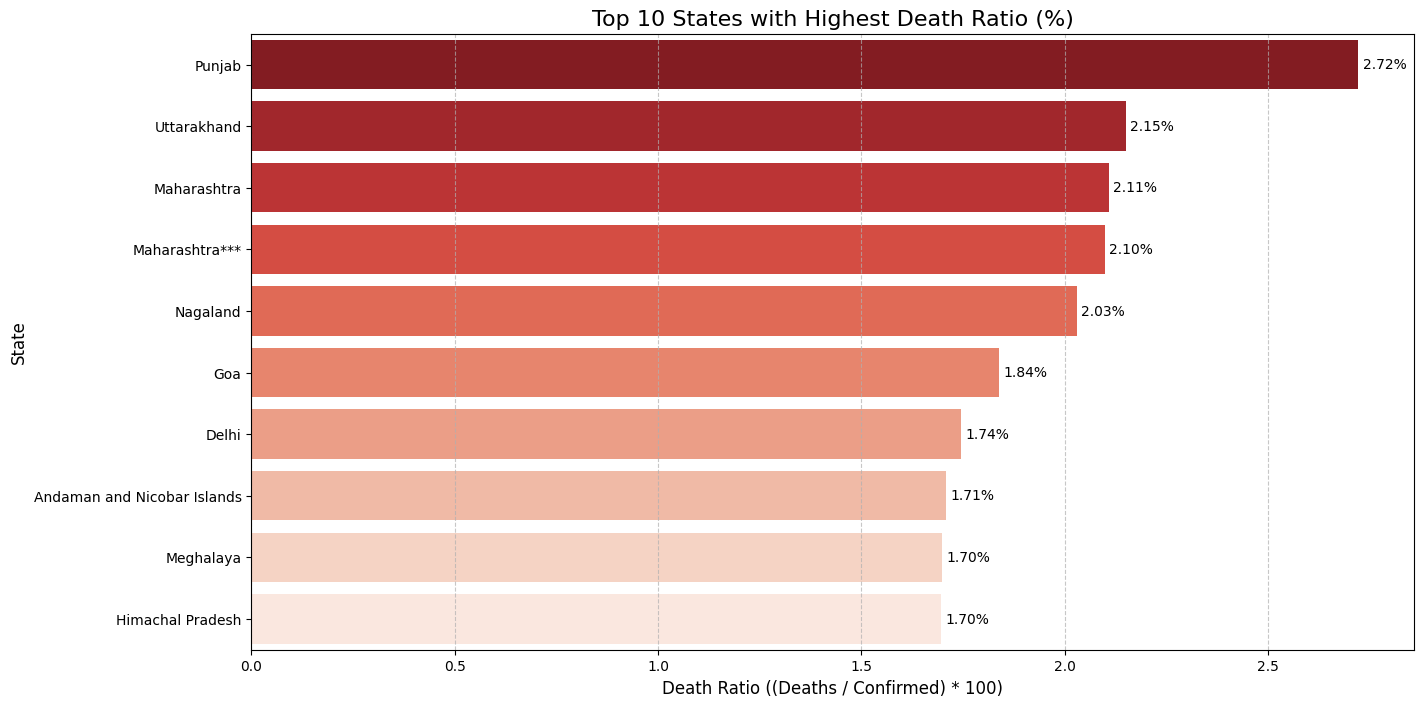

In [47]:
latest_data = dataindia.sort_values('Date').groupby('State').tail(1)

latest_data['Death_Ratio'] = (latest_data['Deaths'] / latest_data['Confirmed']) * 100

top_10_mortality = latest_data.sort_values('Death_Ratio', ascending=False).head(10)

plt.figure(figsize=(15, 8))
barplot = sns.barplot(data=top_10_mortality, x='Death_Ratio', y='State', palette='Reds_r')

plt.title('Top 10 States with Highest Death Ratio (%)', fontsize=16)
plt.xlabel('Death Ratio ((Deaths / Confirmed) * 100)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i in barplot.containers:
    barplot.bar_label(i, fmt='%.2f%%', padding=3)

plt.show()